In [1]:
import emcee_run as em

File with interpolation object exists:  ../interpolating_objects/CDEfittings-interpObj-new.sav
Loading file from joblib


In [2]:
em.truth_omegam

0.32

In [3]:
sampler = em.run_emcee_mp(1000)

50273698210.922844


100%|██████████| 1000/1000 [1:25:21<00:00,  5.62s/it]


In [4]:
sampler = _

In [5]:
sampler

In [9]:
ndim =2

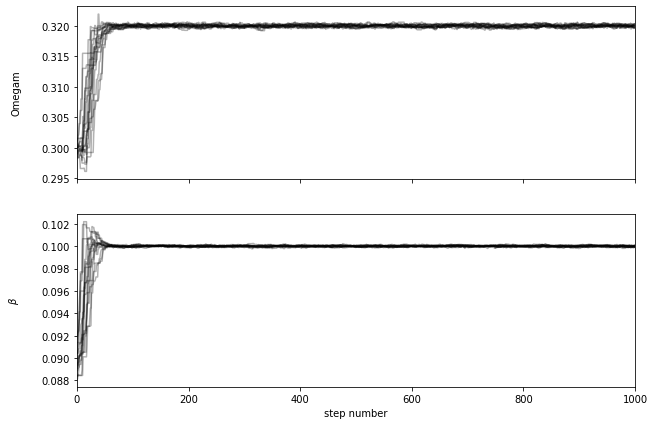

In [16]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Omegam", "$\\beta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [12]:
flat_samples = sampler.get_chain(discard=200, thin=5, flat=True)

In [14]:
np.savetxt('fitting-formula-beta.txt',flat_samples)

In [17]:
em.truth_beta

0.1

In [18]:
em.truth_omegam

0.32

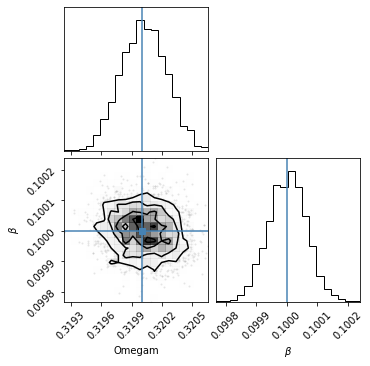

In [19]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[em.truth_omegam, em.truth_beta]
);


In [21]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [33, 50, 67])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
0.0001/0.32

0.0003125